In [456]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.measure import regionprops, label
from skimage.io import imread

data = Path("/Users/zestros/my_prog/my_python/task/")
FEATURES_NUM = 15
hu_k = 1
as_k = 5
ec_k = 5
s_k = 10
ex_k = 20
e_k = 5
rx_k = 8
ry_k = 8
cc_k = 1
h7_k = 1

In [457]:
def extractor_train(image):
    if image.ndim == 2:
        binary_image=image
    else:
        gray = np.mean(image,2).astype("u1")
        binary_image = gray > 10


    labeled = label(binary_image)
    regions = sorted(regionprops(labeled), key=lambda r: r.bbox[1])
    final_features = []
    skip_idx = set()

    for i in range(len(regions)):
        if i in skip_idx:
            continue
        plt.imshow(regions[i].image)
            
        curr = regions[i]
        
        r1_min_y, r1_min_x, r1_max_y, r1_max_x = curr.bbox
        
        found_pair = False
        for j in range(i + 1, min(i + 4, len(regions))):
            if j in skip_idx: continue
            
            neighbor = regions[j]
            r2_min_y, r2_min_x, r2_max_y, r2_max_x = neighbor.bbox
            
            dist_x = abs(curr.centroid[1] - neighbor.centroid[1])
            
            
            if dist_x < 20 and (((0 <= r2_min_y - r1_max_y  < 30) and (r2_min_y > r1_max_y)) \
                or ((0 <= r1_min_y - r2_max_y < 30) and (r2_min_y < r1_max_y))):
                
                min_y, min_x = min(r1_min_y, r2_min_y), min(r1_min_x, r2_min_x)
                max_y, max_x = max(r1_max_y, r2_max_y), max(r1_max_x, r2_max_x)
                
                height = max_y - min_y
                width = max_x - min_x
                combined_mask = np.zeros((height, width), dtype=np.uint8)
                
                combined_mask[r1_min_y-min_y:r1_max_y-min_y, r1_min_x-min_x:r1_max_x-min_x] |= curr.image
                combined_mask[r2_min_y-min_y:r2_max_y-min_y, r2_min_x-min_x:r2_max_x-min_x] |= neighbor.image

                props = regionprops(combined_mask.astype(int))[0]
                # Признаки
                hu = (-np.sign(props.moments_hu) * np.log10(np.abs(props.moments_hu) + 1e-20)) * hu_k

                r_min_y, r_min_x, r_max_y, r_max_x = props.bbox
                
                h = r_max_y - r_min_y
                w = r_max_x - r_min_x
                aspect_ratio = h / w
                eccentricity = props.eccentricity
                solidity = props.solidity
                extent = props.area / (h * w) if (h * w) > 0 else 0
                euler = props.euler_number 
                centroid_y, centroid_x = props.centroid
                rel_centroid_y = (centroid_y - r_min_y) / h
                rel_centroid_x = (centroid_x - r_min_x) / w
                compactness = (props.perimeter**2) / (4 * np.pi * props.area)
                hu_list = list(hu)
                hu_list[6] *= h7_k 
                features = hu_list + [aspect_ratio * as_k, eccentricity * ec_k, solidity * s_k, extent * ex_k, euler * e_k, rel_centroid_y *rx_k, rel_centroid_y *ry_k, compactness * cc_k]
                final_features.append((features, (min_y, min_x, max_y, max_x)))
                skip_idx.add(j)
                found_pair = True
                break
        
        if not found_pair:
            
            hu = (-np.sign(curr.moments_hu) * np.log10(np.abs(curr.moments_hu) + 1e-20)) * hu_k

            r_min_y, r_min_x, r_max_y, r_max_x = curr.bbox
                
            h = r_max_y - r_min_y
            w = r_max_x - r_min_x
            aspect_ratio = h / w
            eccentricity = curr.eccentricity
            solidity = curr.solidity
            extent = curr.area / (h * w) if (h * w) > 0 else 0
            euler = curr.euler_number  
            centroid_y, centroid_x = curr.centroid
            rel_centroid_y = (centroid_y - r_min_y) / h
            rel_centroid_x = (centroid_x - r_min_x) / w
            compactness = (curr.perimeter**2) / (4 * np.pi * curr.area)
            hu_list = list(hu)
            hu_list[6] *= h7_k 
            features = hu_list + [aspect_ratio * as_k, eccentricity * ec_k, solidity * s_k, extent * ex_k, euler * e_k, rel_centroid_y *rx_k, rel_centroid_y *ry_k, compactness * cc_k]    
            final_features.append((features, curr.bbox))
            
    return final_features

In [458]:
def make_train(path):
    train = []
    responses = []
    class_names = {}
    ncls = 0
    folders = sorted(p for p in path.glob("*") if p.is_dir() and not p.name.startswith("."))
    for cls_folder in folders:
        ncls += 1
        class_names[ncls] = cls_folder.name
        #print(ncls,cls_folder.name)
        for p in cls_folder.glob("*.png"):
            if p.name.startswith("."): continue
            
            img = imread(p)
            feats = extractor_train(img)
            if len(feats) > 0:
                train.append(feats[0][0])
                responses.append(ncls)
    train = np.array(train, dtype="f4").reshape(-1, FEATURES_NUM)
    responses = np.array(responses, dtype="f4").reshape(-1, 1)
    return train, responses, class_names

Надпись: C is LOW-LEVEL


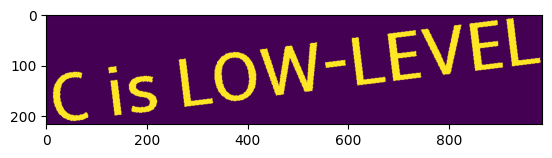

Надпись: C++ is POWERFUL


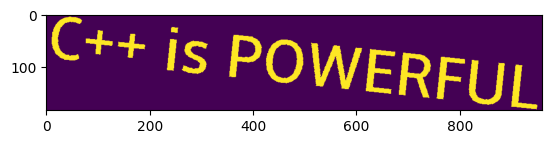

Надпись: Python is INTUITIVE


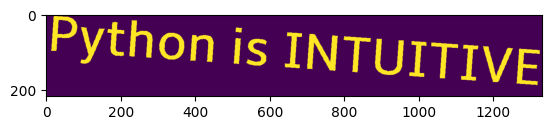

Надпись: RuNt iN SAFE


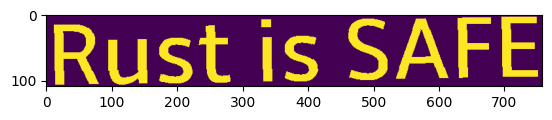

Надпись: LUA iN EASY


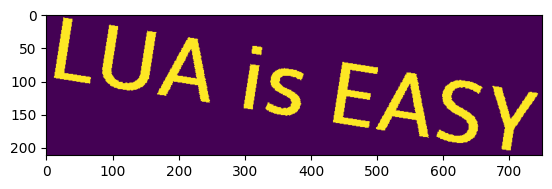

Надпись: Javascript is UGLY


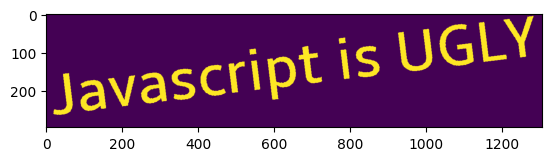

Надпись: PNP sucys


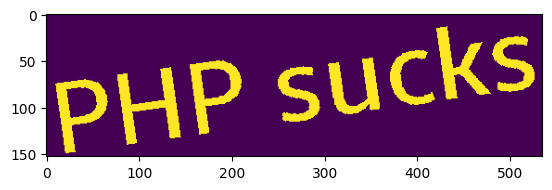

In [463]:
for i in range(0,7):
    image = imread(data / f"{i}.png")
    find = extractor_train(image)
    bboxes = [item[1] for item in find]
    find = np.array([item[0] for item in find], dtype="f4").reshape(-1, FEATURES_NUM)
    
    find = np.array(find, dtype="f4").reshape(-1, FEATURES_NUM)
    
    train, responses, alphabet = make_train(data / "train")
    
    knn = cv2.ml.KNearest.create()
    knn.train(train, cv2.ml.ROW_SAMPLE, responses)
    
    ret, result, neighbours, dist = knn.findNearest(find, 1)

    message = ""
    prev_max_x = None
    
    for i in range(len(result)):
        idx = int(result[i][0])
        letter = alphabet[idx]
        if len(letter) > 1 and letter.startswith('s'):
            letter = letter[1:]
        
        curr_min_x = bboxes[i][1] 
        curr_max_x = bboxes[i][3]
        
        if prev_max_x is not None:
            gap = curr_min_x - prev_max_x
            if gap > 20:
                message += " "             
        message += letter
        prev_max_x = curr_max_x
    
    print(f"Надпись: {message}")
    
    gray = np.mean(image,2).astype("u1")
    binary_image = gray > 10
    plt.imshow(binary_image)
    
    plt.show()

In [ ]:
# 5 ошибок из 85 букв = 5.88% ошибка

In [455]:
print( find[:100])

[[  0.39460763   1.6973159    1.6737189    2.9919727    5.469496
    3.9752967   -8.221999     7.017544     3.6061904    5.6120467
    7.6008773    0.           3.163647     3.163647     6.213961  ]
 [  0.34462473   2.6815836    4.0714307    4.2808795    8.4576435
    5.623358   -14.600197     6.0869565    2.1405737    4.432139
    7.042788     5.           3.9437718    3.9437718    6.9181314 ]
 [  0.39303067   1.6868593    1.6748937    2.9931903    5.476616
    3.9742916   -8.2183275    7.142857     3.6174123    5.6401043
    7.709821     0.           3.131384     3.131384     6.2389574 ]
 [  0.40298823   1.4954015    3.7562487    5.1343846   -9.981309
    6.472576   -14.425305     6.521739     3.9456835    5.258772
    8.688406     5.           4.0394773    4.0394773    5.7599087 ]
 [  0.40203995   3.3380208    2.7993174    3.062486    -5.998737
   -5.012084    10.200446     5.446429     1.6016335    5.3498387
    8.729508     5.           4.284329     4.284329     5.240092  ]
 [  0.

In [277]:
import numpy as np
from skimage.measure import label, regionprops

def extractor(image):
    if image.ndim == 2:
        binary_image=image
    else:
        gray = np.mean(image,2).astype("u1")
        binary_image = gray > 10


    labeled = label(binary_image)
    regions = sorted(regionprops(labeled), key=lambda r: r.bbox[1])
    final_features = []
    skip_idx = set()

    for i in range(len(regions)):
        if i in skip_idx:
            continue
        plt.imshow(regions[i].image)
            
        curr = regions[i]
        
        r1_min_y, r1_min_x, r1_max_y, r1_max_x = curr.bbox
        
        found_pair = False
        for j in range(i + 1, min(i + 4, len(regions))):
            if j in skip_idx: continue
            
            neighbor = regions[j]
            r2_min_y, r2_min_x, r2_max_y, r2_max_x = neighbor.bbox
            
            dist_x = abs(curr.centroid[1] - neighbor.centroid[1])
            
            
            if dist_x < 20 and (((0 <= r2_min_y - r1_max_y  < 30) and (r2_min_y > r1_max_y)) \
                or ((0 <= r1_min_y - r2_max_y < 30) and (r2_min_y < r1_max_y))):
                print(dist_x)
                min_y, min_x = min(r1_min_y, r2_min_y), min(r1_min_x, r2_min_x)
                max_y, max_x = max(r1_max_y, r2_max_y), max(r1_max_x, r2_max_x)
                
                height = max_y - min_y
                width = max_x - min_x
                combined_mask = np.zeros((height, width), dtype=np.uint8)
                
                combined_mask[r1_min_y-min_y:r1_max_y-min_y, r1_min_x-min_x:r1_max_x-min_x] |= curr.image
                combined_mask[r2_min_y-min_y:r2_max_y-min_y, r2_min_x-min_x:r2_max_x-min_x] |= neighbor.image

                plt.figure(figsize=(2, 2))
                plt.imshow(combined_mask, cmap='gray')
                plt.title(f"Combined {i}+{j}")
                plt.axis('off')
                plt.show()
                
                
                props = regionprops(combined_mask.astype(int))[0]
                # Признаки
                hu = -np.sign(props.moments_hu) * np.log10(np.abs(props.moments_hu) + 1e-20)

                r_min_y, r_min_x, r_max_y, r_max_x = props.bbox
                
                h = r_max_y - r_min_y
                w = r_max_x - r_min_x
                aspect_ratio = h / w
                eccentricity = props.eccentricity
                solidity = props.solidity
                extent = props.area / (h * w) if (h * w) > 0 else 0
                euler = props.euler_number  
                features = list(hu) + [aspect_ratio * as_k, eccentricity * ec_k, solidity * s_k, extent * ex_k, euler * e_k]
                final_features.append((features, (min_y, min_x, max_y, max_x)))
                skip_idx.add(j)
                found_pair = True
                break
        
        if not found_pair:
            
            plt.figure(figsize=(2, 2))
            plt.imshow(curr.image, cmap='gray')
            plt.title(f"Single {i}")
            plt.axis('off')
            plt.show()
            
            hu = -np.sign(curr.moments_hu) * np.log10(np.abs(curr.moments_hu) + 1e-20)

            r_min_y, r_min_x, r_max_y, r_max_x = curr.bbox
                
            h = r_max_y - r_min_y
            w = r_max_x - r_min_x
            aspect_ratio = h / w
            eccentricity = curr.eccentricity
            solidity = curr.solidity
            extent = curr.area / (h * w) if (h * w) > 0 else 0
            euler = curr.euler_number  
            features = list(hu) + [aspect_ratio * as_k, eccentricity * ec_k, solidity * s_k, extent * ex_k, euler * e_k]
            final_features.append((features, curr.bbox))
            
    return final_features
